In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
from libs.MSCTDdataset import MSCTD
from torch.utils.data import Dataset, DataLoader
from libs.transforms import Compose,toTensor,resize
from torchvision.transforms import ToTensor, Resize
import torch
import torch.nn as nn
from torchvision.transforms import ToTensor, Resize, Compose
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import numpy as np
import PIL 
import os
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

import matplotlib.pyplot as plt
import seaborn as sb


# Pre-Processing 

In [4]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /home/user01/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/user01/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/user01/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/user01/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [5]:
transforms = Compose([resize(dstsize=(224,224))])

root_dir = '.'

training_data_single = MSCTD(
        mode='train', 
        transformer=transforms,
        download=False,
        root_dir=root_dir,
        read_mode="single")

valid_data_single = MSCTD(
        mode='validation',
        transformer=transforms,
        download=False,
        root_dir=root_dir,
        read_mode="single")

test_data_single = MSCTD(
        mode='test',
        transformer=transforms,
        download=False,
        root_dir=root_dir,
        read_mode="single")

In [6]:
batch_size = 32
train_dataloader = DataLoader(training_data_single, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_data_single, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data_single, batch_size=batch_size, shuffle=True)

In [7]:
# training Dataframe
training_data_sentiment = [int(i) for i in training_data_single.sentiment]
training_data = pd.DataFrame( data = {'sentences': training_data_single.english_text , 'sentiment': training_data_sentiment})

# training Dataframe
valid_data_sentiment = [int(i) for i in valid_data_single.sentiment]
valid_data = pd.DataFrame( data = {'sentences': valid_data_single.english_text , 'sentiment': valid_data_sentiment})

# test Dataframe
test_data_sentiment = [int(i) for i in test_data_single.sentiment]
test_data = pd.DataFrame( data = {'sentences': test_data_single.english_text , 'sentiment': test_data_sentiment})

In [8]:
# pre-processing function
def prep(review):
    
    # Remove non-letters
    review = re.sub("[^a-zA-Z]", " ", review)
    
    # Lower case
    review = review.lower()

    # Remove extra spaces
    review = re.sub(' +', ' ', review)
    
    # Tokenize to each word.
    token = nltk.word_tokenize(review)

    # Remove Stopwords
    stop = stopwords.words('english')
    review = [w for w in token if w not in stop]

    # Stemming
    review = [nltk.stem.SnowballStemmer('english').stem(w) for w in review]


    # lemmatization 
    lemmatizer = WordNetLemmatizer()
    review = [lemmatizer.lemmatize(w) for w in review]

    # Join the words back into one string separated by space, and return the result.
    return " ".join(review)
    

In [9]:
training_data['clean'] = training_data['sentences'].apply(prep)
valid_data['clean'] = valid_data['sentences'].apply(prep)
test_data['clean'] = test_data['sentences'].apply(prep)

In [10]:
training_data

,sentences,sentiment,clean
0,Okay. I'm confused.,0,okay confus
1,"You don't care if I go to Paris with Jane,",0,care go pari jane
2,"I'm sorry. I have to tell you something,",1,sorri tell someth
3,I have to go.,1,go
4,I'm an accessory to murder.,1,accessori murder
...,...,...,...
20235,"Hey, this is for charity.",2,hey chariti
20236,You know you're taking those jeans out of the ...,0,know take jean hand
20237,"You know they're not getting the actual jeans,...",0,know get actual jean right luke
20238,"Oh. Right. Well, then how about a donation?",2,oh right well donat


In [11]:
valid_data

,sentences,sentiment,clean
0,He diagnosed Andy with growing pains.,0,diagnos andi grow pain
1,"But, you know, I grew up,",0,know grew
2,Your pain is dramatic to me.,1,pain dramat
3,Andy. your mom's right.,0,andi mom right
4,It's a good thing that you came.,0,good thing came
...,...,...,...
5058,Your van crashed.,1,van crash
5059,"No one was hurt, but we need to get you examined.",2,one hurt need get examin
5060,Come on.,1,come
5061,I must have fallen asleep at the wheel for a s...,2,must fallen asleep wheel second


In [12]:
test_data

,sentences,sentiment,clean
0,With this asshole?,1,asshol
1,"Two guys walk in, one walks out.",1,two guy walk one walk
2,"I'm not happy about it either, okay? At all.",1,happi either okay
3,"But, for now, it's done.",1,done
4,You're on admin leave until they make a determ...,0,admin leav make determin batteri
...,...,...,...
5062,"Han, you stand there and try to look smart.",2,han stand tri look smart
5063,"Ah. I'm already Asian. So, done.",2,ah alreadi asian done
5064,"Wow, this brings me back.",0,wow bring back
5065,"I had a seat at the popular table,",0,seat popular tabl


# A) Word Representation

## Part 1: tf-idf vectors

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import words
from wordcloud import WordCloud, STOPWORDS


In [14]:
tv = TfidfVectorizer(ngram_range = (1,3), sublinear_tf = True, max_features = 40000)

In [15]:
train_tv = tv.fit_transform(training_data['clean'])
test_tv = tv.transform(test_data['clean'])

In [16]:
vocab = tv.get_feature_names_out()
vocab

array(['aaron', 'abdomen', 'abl', ..., 'zuckerberg', 'zup', 'zz'],
      dtype=object)

In [17]:
dist = np.sum(train_tv, axis=0)
checking = pd.DataFrame(dist,columns = vocab)

In [18]:
def cloud(data,backgroundcolor = 'white', width = 800, height = 600):
    wordcloud = WordCloud(stopwords = STOPWORDS, background_color = backgroundcolor,
                         width = width, height = height).generate(data)
    plt.figure(figsize = (15, 10))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()

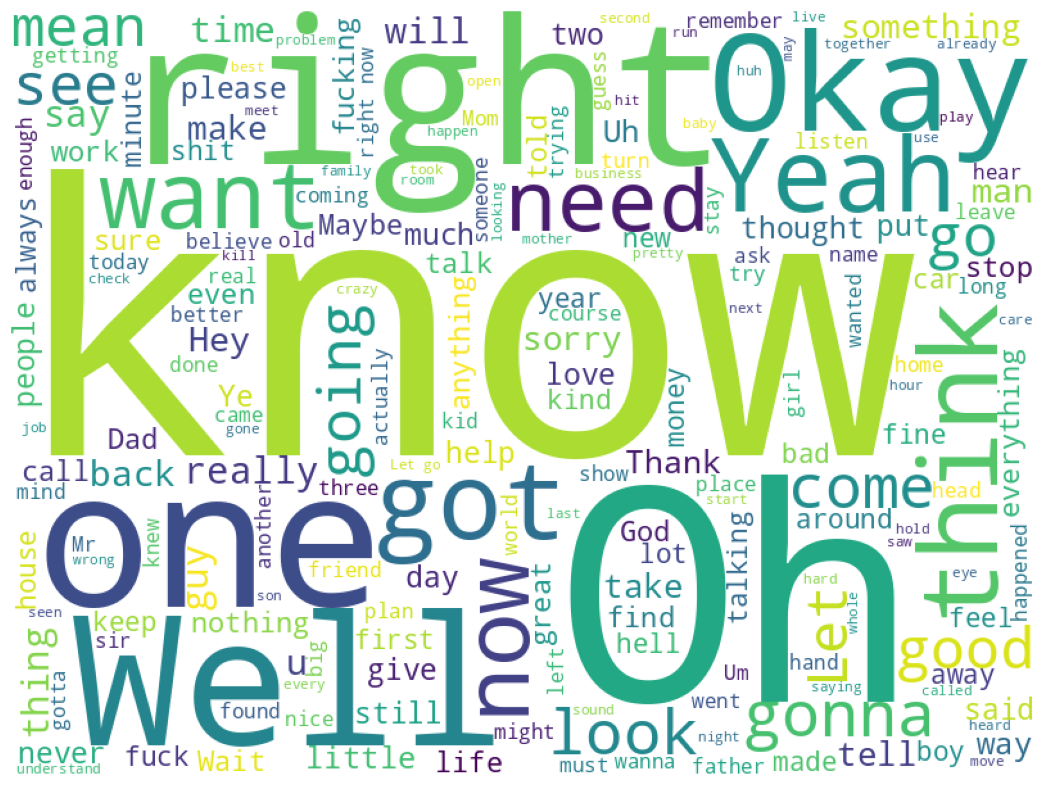

In [19]:
cloud(' '.join(training_data['sentences']))

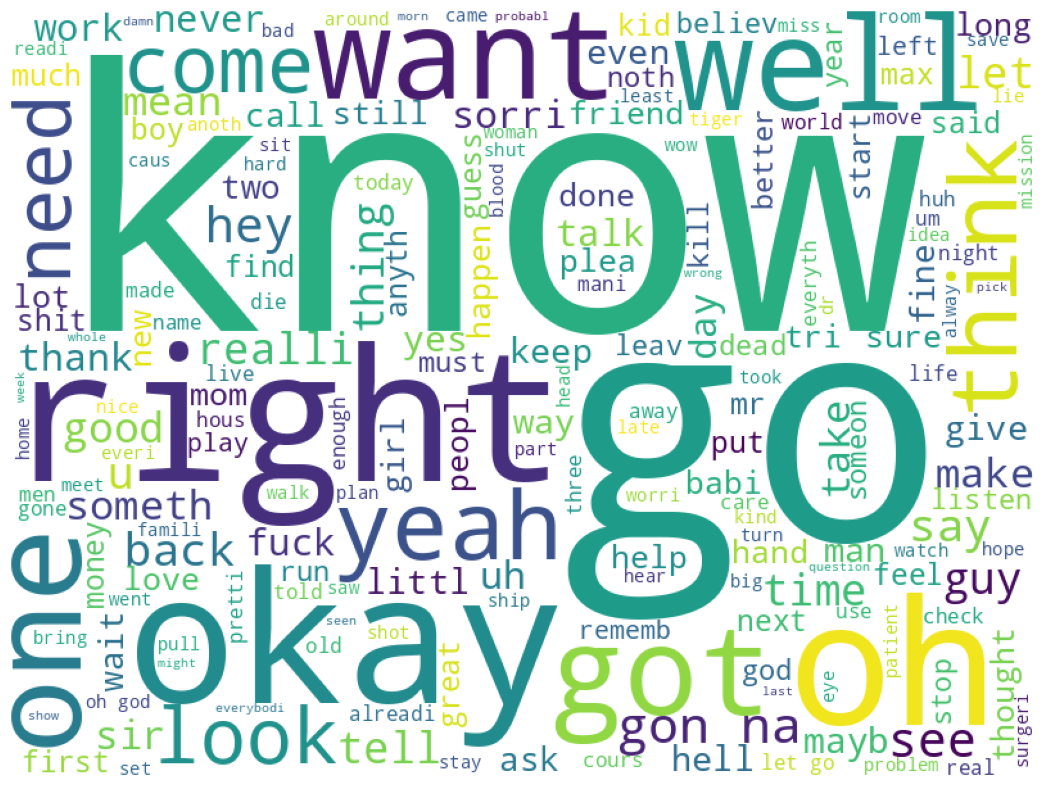

In [20]:
cloud(' '.join(test_data['clean']))

* SVM

In [21]:
from sklearn.svm import LinearSVC
clf = LinearSVC(random_state=0)
clf.fit(train_tv, training_data['sentiment'])
y_pred=clf.predict(test_tv)

In [22]:
print(classification_report(y_true=test_data['sentiment'], y_pred=y_pred, target_names=['neutral','negative','positive']))

              precision    recall  f1-score   support

     neutral       0.35      0.49      0.41      1298
    negative       0.56      0.54      0.55      2163
    positive       0.53      0.40      0.45      1606

    accuracy                           0.48      5067
   macro avg       0.48      0.47      0.47      5067
weighted avg       0.50      0.48      0.48      5067



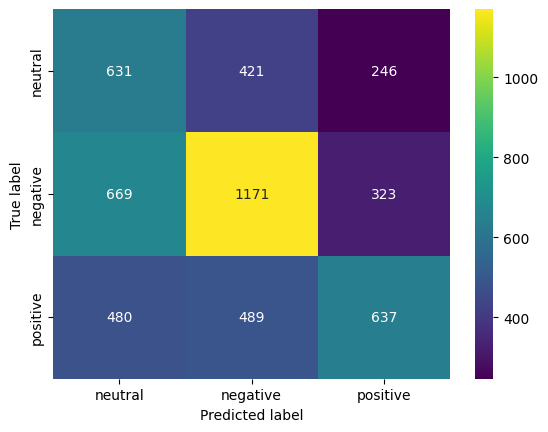

In [23]:
cf_matrix = confusion_matrix(y_true=test_data['sentiment'], y_pred=y_pred)

sb.heatmap(cf_matrix,
           annot=True,
           fmt='d',
           cmap='viridis',
           xticklabels=['neutral','negative','positive'],
           yticklabels=['neutral','negative','positive'])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

* Logistic Regression

In [24]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(max_iter=1000,solver='saga')
clf.fit(train_tv, training_data['sentiment'])
y_pred=clf.predict(test_tv)

In [25]:
print(classification_report(y_true=test_data['sentiment'], y_pred=y_pred, target_names=['neutral','negative','positive']))

              precision    recall  f1-score   support

     neutral       0.37      0.51      0.43      1298
    negative       0.56      0.58      0.57      2163
    positive       0.57      0.38      0.45      1606

    accuracy                           0.50      5067
   macro avg       0.50      0.49      0.48      5067
weighted avg       0.52      0.50      0.50      5067



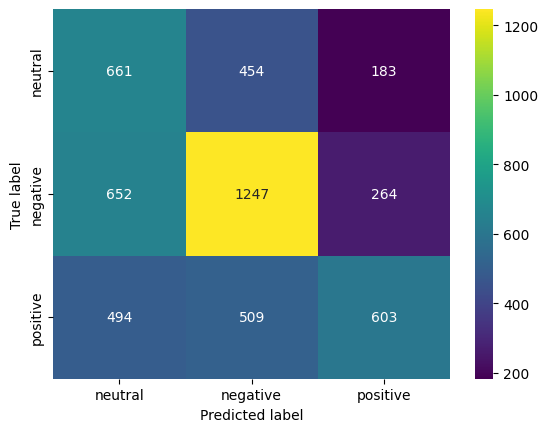

In [26]:
cf_matrix = confusion_matrix(y_true=test_data['sentiment'], y_pred=y_pred)

sb.heatmap(cf_matrix,
           annot=True,
           fmt='d',
           cmap='viridis',
           xticklabels=['neutral','negative','positive'],
           yticklabels=['neutral','negative','positive'])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

* MLP

In [27]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(hidden_layer_sizes=(5), max_iter=1000, activation = 'relu', solver='adam', random_state=1)
clf.fit(train_tv, training_data['sentiment'])
y_pred=clf.predict(test_tv)

In [28]:
print(classification_report(y_true=test_data['sentiment'], y_pred=y_pred, target_names=['neutral','negative','positive']))

              precision    recall  f1-score   support

     neutral       0.33      0.48      0.39      1298
    negative       0.54      0.47      0.50      2163
    positive       0.47      0.38      0.42      1606

    accuracy                           0.44      5067
   macro avg       0.45      0.44      0.44      5067
weighted avg       0.46      0.44      0.45      5067



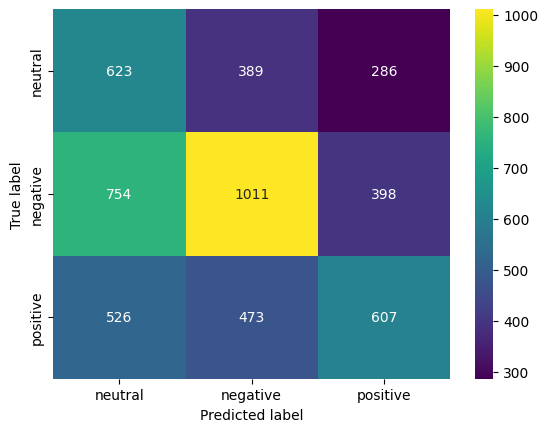

In [29]:
cf_matrix = confusion_matrix(y_true=test_data['sentiment'], y_pred=y_pred)

sb.heatmap(cf_matrix,
           annot=True,
           fmt='d',
           cmap='viridis',
           xticklabels=['neutral','negative','positive'],
           yticklabels=['neutral','negative','positive'])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

# Part 2

In [30]:
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import words
from sklearn.decomposition import TruncatedSVD
from scipy.sparse import csr_matrix
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from collections import OrderedDict

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [31]:
def get_feature(data,analyze,vocab):
  a=[]
  for i in list(map(analyze,data)):
    b=[]
    for j in i:
      if j in vocab:
        b.append(j)
    a.append(b)
  return a
  
tv = TfidfVectorizer(ngram_range = (1,1), sublinear_tf = True,stop_words='english', max_features = 1000)
Xtrain_tv = tv.fit_transform(training_data['clean'])
Xtest_tv = tv.transform(test_data['clean'])
analyze = tv.build_analyzer()
vocab = tv.get_feature_names_out ()
training_data['feature'] = get_feature(training_data['clean'].values,analyze,vocab) 
test_data['feature'] = get_feature(test_data['clean'].values,analyze,vocab) 

In [32]:
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import words
from sklearn.decomposition import TruncatedSVD
from scipy.sparse import csr_matrix
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler


class sudoWord2Vec:
  def __init__(self,Dataset_train:pd.DataFrame,Dataset_test:pd.DataFrame,Xtrain_tv,Xtest_tv,tv):
    self.Dataset_train=Dataset_train
    self.Dataset_test=Dataset_test

    self.Xtrain_tv = Xtrain_tv
    self.Xtest_tv = Xtest_tv
    self.tv = tv
    # self.tv = TfidfVectorizer(ngram_range = (1,3), sublinear_tf = True, max_features = 500)
    # self.Xtrain_tv = self.tv.fit_transform(self.Dataset_train['clean'])
    # self.Xtest_tv = self.tv.transform(self.Dataset_test['clean'])
    # self.analyze = self.tv.build_analyzer()
    self.scaler = StandardScaler()
    # self.Dataset_train['feature'] = get_feature(self.Dataset_train['clean'].values,self.analyze) #list(map(self.analyze,self.Dataset_train['clean'].values))
    # self.Dataset_test['feature'] = get_feature(self.Dataset_test['clean'].values,self.analyze) #list(map(self.analyze,self.Dataset_test['clean'].values))

    self.svd_train = TruncatedSVD(n_components=250, n_iter=7, random_state=42)
    self.svd_test = TruncatedSVD(n_components=250, n_iter=7, random_state=42)
    self.Xtrain_tv_reduced = self.scaler.fit_transform(self.svd_train.fit_transform(self.Xtrain_tv.transpose()))
    self.Xtest_tv_reduced = self.scaler.fit_transform(self.svd_test.fit_transform(self.Xtest_tv.transpose()))

    self.vocab = self.tv.get_feature_names_out ()
    
  def run_svd(self,query_vocab):
    
    include_list=self.Dataset_train[list(map(lambda x: query_vocab in x,self.Dataset_train['feature'].values))]['feature'].values
    exclude_list=self.Dataset_train[list(map(lambda x: query_vocab not in x,self.Dataset_train['feature'].values))]['feature'].values
    Xt=self.Xtrain_tv_reduced

    minus_list=np.array(list(set(np.concatenate(exclude_list).tolist())))

    W=[]
    b=[]
    y_pred=[]
    y_true=[]
    for i in include_list:
      self.clf = LinearSVC(random_state=0,C=1e-1,dual=False)
      l=len(i)
      # minus_list=sorted(exclude_list[list(map(lambda x:len(x)>=l,exclude_list))], key=len, reverse=False)[0]
      # minus_list=np.array(list(set(np.concatenate(exclude_list).tolist())))
      
      minus_selected=minus_list[np.random.randint(0,len(minus_list),size=(l)).tolist()]

      X_plus=Xt[np.array(np.where(self.vocab==np.array(i)[:,None].tolist())[1]).reshape(-1,)]
      X_minus=Xt[np.array(np.where(self.vocab==minus_selected[:,None].tolist())[1]).reshape(-1,)]

      y_plus=np.ones(len(X_plus))
      y_minus=np.ones(len(X_minus))*-1
 
      X_total=np.concatenate((X_plus,X_minus))

      y_total=np.concatenate((y_plus,y_minus))
      self.clf.fit(X_total,y_total)
      
      W.append(self.clf.coef_)
      b.append(self.clf.intercept_)
     
      
      y_pred.append(self.clf.predict(X_total))
      y_true.append(y_total)
    
    # print(classification_report(np.concatenate(y_true).reshape(-1,),np.concatenate(y_pred).reshape(-1,)))
    return np.mean(W,axis=0).T,np.mean(b)

  def run_test(self,Result):
    
    query_vocab= Result[0]
    W=Result[1][0]
    b=Result[1][1]

    include_list=self.Dataset_test[list(map(lambda x: query_vocab in x,self.Dataset_test['feature'].values))]['feature'].values
    exclude_list=self.Dataset_test[list(map(lambda x: query_vocab not in x and len(x)>0,self.Dataset_test['feature'].values))]['feature'].values
        
    Xt=self.Xtest_tv_reduced

    minus_list=np.array(list(set(np.concatenate(exclude_list).tolist())))

    y_pred=[]
    y_true=[]
    for i in include_list:
      l=len(i)
      
      
      minus_selected=minus_list[np.random.randint(0,len(minus_list),size=(l)).tolist()]
      
      X_plus=Xt[np.array(np.where(self.vocab==np.array(i)[:,None].tolist())).reshape(-1,)]
      X_minus=Xt[np.array(np.where(self.vocab==np.array(minus_selected)[:,None].tolist())).reshape(-1,)]

      y_plus=np.ones(len(X_plus))
      y_minus=np.ones(len(X_minus))*-1

      X_total=np.concatenate((X_plus,X_minus))

      y_total=np.concatenate((y_plus,y_minus))
      
      
      
      y_pred.append(np.sign(X_total@W +b))
      y_true.append(y_total)
    if len(y_true):
      # print(classification_report(np.concatenate(y_true).reshape(-1,),np.concatenate(y_pred).reshape(-1,)))
      return np.concatenate(y_true).reshape(-1,),np.concatenate(y_pred).reshape(-1,)

    else :
      return np.array([]),np.array([])
  
  def run_total_vocab(self):
    Result=[]
   
    print("Run on Train ....")
    for i in tqdm(self.vocab):
      param=self.run_svd(i)
      Result.append((i,param))
    return Result

  def run_test_total(self,Result):
    y_true_test=[]
    y_pred_test=[]
    print("Run on Test ....")
    for i in tqdm(range(len(Result))):
      a,b=self.run_test(Result[i])
      y_true_test.append(a)
      y_pred_test.append(b)
    print(classification_report(np.concatenate(y_true_test).reshape(-1,),np.concatenate(y_pred_test).reshape(-1,)))
    return np.concatenate(y_true_test).reshape(-1,),np.concatenate(y_pred_test).reshape(-1,)

 

In [33]:
A=sudoWord2Vec(training_data,test_data,Xtrain_tv,Xtest_tv,tv)

In [34]:
Result=A.run_total_vocab()

Run on Train ....


100%|██████████| 1000/1000 [01:05<00:00, 15.26it/s]


In [35]:
A.run_test_total(Result)

Run on Test ....


100%|██████████| 1000/1000 [00:06<00:00, 145.01it/s]


              precision    recall  f1-score   support

        -1.0       0.53      0.89      0.66     50646
         1.0       0.66      0.22      0.33     50646

    accuracy                           0.55    101292
   macro avg       0.59      0.55      0.50    101292
weighted avg       0.59      0.55      0.50    101292



(array([ 1.,  1.,  1., ..., -1., -1., -1.]),
 array([ 1.,  1., -1., ..., -1., -1., -1.]))

### training RNN to predict class of each sentences

In [36]:
def tensorFromSentence(Result, sentence):
  feature_list=[]
  for i in sentence:
    w,b=Result[i]

    feature_list.append(torch.tensor(np.concatenate((w[:,0],np.array([b]))))[None,:])
  if len(feature_list)>1:
    return torch.concatenate(feature_list,).to(device)
  elif len(feature_list)==1:
    return feature_list[0].to(device)
  else :
    return torch.tensor([]).to(device)

In [38]:
class ClsRnnNetwork(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(ClsRnnNetwork, self).__init__()
        self.hidden_size = hidden_size

        # self.embedding = nn.Embedding(input_size, hidden_size)

        self.gru = nn.GRU(input_size, hidden_size)
        self.cls = nn.Sequential(OrderedDict([
          ('FC1', nn.Linear(in_features=251,out_features=125)),
          ('relu1', nn.ReLU()),
          ('dropout',nn.Dropout(p=0.5)),
          ('Fc2', nn.Linear(in_features=125,out_features=3))
        ]))

    def forward(self, input):
        # embedded = self.embedding(input).view(1, 1, -1)
        # output = embedded
        for i in input:
          output, _ = self.gru(i.view(1, 1, -1))
          
        logits=self.cls(output)
        
        return logits

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [39]:
def clacModel(model, input_tensor, target_class, model_optimizer, criterion):

   model_optimizer.zero_grad()

   input_length = input_tensor.size(0)
   loss = 0
   epoch_loss = 0
   correct = 0

   
   output = model(input_tensor)
#calculate the loss from a predicted sentence with the expected result

   loss += criterion(output[0], target_class.view(1))
   pred = torch.argmax(output[0])
   correct = 1 if pred==target_class else 0
   
   loss.backward()
   model_optimizer.step()
   epoch_loss = loss.item()

   return epoch_loss,correct

In [44]:
def trainModel(model,Dataset_train,Dataset_test, Result, num_iteration=20,type='GRU'):
   Result_dict=dict(Result)
   
   

  
   optimizer = optim.Adam(model.parameters(), lr=0.001,weight_decay=1e-5)
   criterion = nn.CrossEntropyLoss()

   total_loss_iterations = 0
   final_score = 0
   total_correct = 0
   counter = 0
   training_tensors = [tensorFromSentence(Result_dict,Dataset_train['feature'][i]) for i in range(len(Dataset_train))]
   test_tensors = [tensorFromSentence(Result_dict,Dataset_train['feature'][i]) for i in range(len(Dataset_test))]
   sentiments_train = Dataset_train['sentiment']
   sentiments_test = Dataset_test['sentiment']
   for epochs in tqdm(range(num_iteration)):
    total_loss_iterations = 0
    counter = 0
    total_correct = 0
    model.train()
    for iter in range(len(Dataset_train)):
        input_tensor = training_tensors[iter].float()
        target_class = torch.tensor(sentiments_train[iter]).to(device)

        if len(input_tensor) == 0:
          continue
        counter+=1
        loss,correct = clacModel(model, input_tensor, target_class, optimizer, criterion)
        
        total_correct += correct
        total_loss_iterations += loss
        
    
    avarage_loss= total_loss_iterations / counter
    avg_acc = total_correct /counter
    tqdm.write(f'iter :{iter} , Loss : {avarage_loss} , Acc :{avg_acc*100}')
    #  scheduler.step()
    torch.save(model.state_dict(), f'checkpoints/phase2_2_{type}_Model.pt')
    # test
    model.eval()
    prediction =[]
    total_loss_iterations = 0
    counter = 0
    total_correct = 0
    for iter in range(len(Dataset_test)):
        input_tensor = training_tensors[iter].float()
        target_class = torch.tensor(sentiments_test[iter]).to(device)
        counter+=1
        if len(input_tensor) == 0:
          output = torch.randn(size=(1,1,3)).to(device)
        else :
          output = model(input_tensor)

        total_loss_iterations += criterion(output[0], target_class.view(1))
        
        pred = torch.argmax(output[0])
        prediction.append(pred)
        correct = 1 if pred==target_class else 0

        total_correct += correct
       

    avarage_loss= total_loss_iterations / counter
    avg_acc = total_correct /counter
    tqdm.write(f'Loss test : {avarage_loss} , Acc test :{avg_acc*100}')


          
   return model,prediction

In [45]:
model =ClsRnnNetwork(251,251)
model.to(device)
model,prediction=trainModel(model,training_data,test_data,Result)

  0%|          | 0/20 [00:25<?, ?it/s]

iter :20239 , Loss : 1.0500809367779371 , Acc :45.81999887709842


  5%|▌         | 1/20 [00:27<08:44, 27.58s/it]

Loss test : 1.1166077852249146 , Acc test :41.247286362739295


  5%|▌         | 1/20 [00:52<08:44, 27.58s/it]

iter :20239 , Loss : 1.0443667173803934 , Acc :46.28600303183426


 10%|█         | 2/20 [00:54<08:12, 27.35s/it]

Loss test : 1.1247732639312744 , Acc test :40.83283994474048


 10%|█         | 2/20 [01:20<08:12, 27.35s/it]

iter :20239 , Loss : 1.0379962751554128 , Acc :46.93728594688675


 15%|█▌        | 3/20 [01:22<07:46, 27.43s/it]

Loss test : 1.123890995979309 , Acc test :40.95125320702586


 15%|█▌        | 3/20 [01:47<07:46, 27.43s/it]

iter :20239 , Loss : 1.0320244398012814 , Acc :47.61664140138117


 20%|██        | 4/20 [01:49<07:19, 27.47s/it]

Loss test : 1.1239721775054932 , Acc test :40.3789224393132


 20%|██        | 4/20 [02:14<07:19, 27.47s/it]

iter :20239 , Loss : 1.0271408243295044 , Acc :48.02650047723317


 25%|██▌       | 5/20 [02:16<06:49, 27.29s/it]

Loss test : 1.12587308883667 , Acc test :39.92500493388593


 25%|██▌       | 5/20 [02:41<06:49, 27.29s/it]

iter :20239 , Loss : 1.0228179480459467 , Acc :48.75077199483465


 30%|███       | 6/20 [02:44<06:21, 27.26s/it]

Loss test : 1.1333235502243042 , Acc test :40.29998026445629


 30%|███       | 6/20 [03:09<06:21, 27.26s/it]

iter :20239 , Loss : 1.0195644299818811 , Acc :49.18308910224019


 35%|███▌      | 7/20 [03:11<05:56, 27.43s/it]

Loss test : 1.1376336812973022 , Acc test :40.18156700217091


 35%|███▌      | 7/20 [03:37<05:56, 27.43s/it]

iter :20239 , Loss : 1.0172040116476526 , Acc :49.09887148391444


 40%|████      | 8/20 [03:39<05:30, 27.53s/it]

Loss test : 1.133102297782898 , Acc test :40.852575488454704


 40%|████      | 8/20 [04:04<05:30, 27.53s/it]

iter :20239 , Loss : 1.014741283767651 , Acc :49.12132951546797


 45%|████▌     | 9/20 [04:06<05:01, 27.42s/it]

Loss test : 1.1346319913864136 , Acc test :39.88553384645747


 45%|████▌     | 9/20 [04:32<05:01, 27.42s/it]

iter :20239 , Loss : 1.0130160893045606 , Acc :49.598562685980575


 50%|█████     | 10/20 [04:34<04:36, 27.65s/it]

Loss test : 1.144637107849121 , Acc test :39.62897177817249


 50%|█████     | 10/20 [05:00<04:36, 27.65s/it]

iter :20239 , Loss : 1.0115519910631436 , Acc :49.63786424119926


 55%|█████▌    | 11/20 [05:02<04:08, 27.65s/it]

Loss test : 1.1465312242507935 , Acc test :39.51055851588711


 55%|█████▌    | 11/20 [05:27<04:08, 27.65s/it]

iter :20239 , Loss : 1.008687301437496 , Acc :50.1712424905957


 60%|██████    | 12/20 [05:29<03:40, 27.53s/it]

Loss test : 1.1408720016479492 , Acc test :40.69469113874087


 60%|██████    | 12/20 [05:54<03:40, 27.53s/it]

iter :20239 , Loss : 1.0066672143917812 , Acc :49.85683004884622


 65%|██████▌   | 13/20 [05:56<03:11, 27.41s/it]

Loss test : 1.1412805318832397 , Acc test :41.247286362739295


 65%|██████▌   | 13/20 [06:22<03:11, 27.41s/it]

iter :20239 , Loss : 1.0039639457109437 , Acc :50.244231093144684


 70%|███████   | 14/20 [06:24<02:44, 27.38s/it]

Loss test : 1.1492598056793213 , Acc test :39.60923623445826


 70%|███████   | 14/20 [06:49<02:44, 27.38s/it]

iter :20239 , Loss : 1.0018812865736775 , Acc :50.31721969569367


 75%|███████▌  | 15/20 [06:51<02:16, 27.34s/it]

Loss test : 1.1493974924087524 , Acc test :39.94474047760016


 75%|███████▌  | 15/20 [07:16<02:16, 27.34s/it]

iter :20239 , Loss : 1.0010033596778583 , Acc :50.66531918477345


 80%|████████  | 16/20 [07:18<01:48, 27.23s/it]

Loss test : 1.1402970552444458 , Acc test :39.33293862245905


 80%|████████  | 16/20 [07:43<01:48, 27.23s/it]

iter :20239 , Loss : 1.0012131661221022 , Acc :50.37336477457751


 85%|████████▌ | 17/20 [07:45<01:21, 27.27s/it]

Loss test : 1.14996337890625 , Acc test :39.35267416617328


 85%|████████▌ | 17/20 [08:10<01:21, 27.27s/it]

iter :20239 , Loss : 1.000429843146725 , Acc :50.485654932345184


 90%|█████████ | 18/20 [08:12<00:54, 27.18s/it]

Loss test : 1.1444393396377563 , Acc test :39.92500493388593


 90%|█████████ | 18/20 [08:37<00:54, 27.18s/it]

iter :20239 , Loss : 0.9974669188299831 , Acc :50.81129638987143


 95%|█████████▌| 19/20 [08:39<00:27, 27.12s/it]

Loss test : 1.15011465549469 , Acc test :39.15531872903099


 95%|█████████▌| 19/20 [09:05<00:27, 27.12s/it]

iter :20239 , Loss : 0.9988309947220555 , Acc :50.491269440233566


100%|██████████| 20/20 [09:07<00:00, 27.37s/it]

Loss test : 1.1466715335845947 , Acc test :39.747385040457864


In [46]:
print(classification_report(y_true=test_data['sentiment'], y_pred=torch.tensor(prediction), target_names=['neutral','negative','positive']))

              precision    recall  f1-score   support

     neutral       0.30      0.10      0.15      1298
    negative       0.43      0.74      0.54      2163
    positive       0.31      0.17      0.22      1606

    accuracy                           0.40      5067
   macro avg       0.35      0.34      0.31      5067
weighted avg       0.36      0.40      0.34      5067



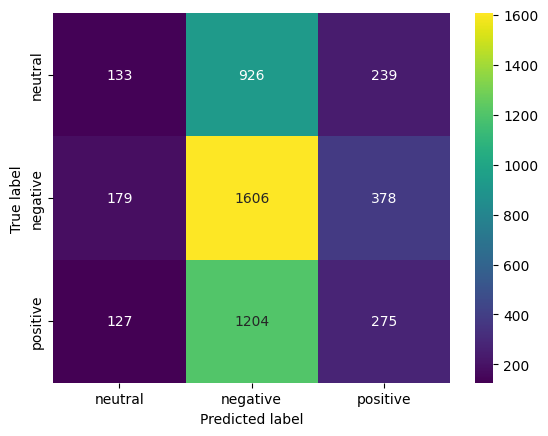

In [50]:
cf_matrix = confusion_matrix(y_true=test_data['sentiment'], y_pred=torch.tensor(prediction))

sb.heatmap(cf_matrix,
           annot=True,
           fmt='d',
           cmap='viridis',
           xticklabels=['neutral','negative','positive'],
           yticklabels=['neutral','negative','positive'])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

# C) Pre-trained Word Representation : GloVe

In [15]:
import torchtext
from libs.glove import GloVe

In [66]:
glove = torchtext.vocab.GloVe(name='6B',dim=50)

.vector_cache/glove.6B.zip: 862MB [07:48, 1.84MB/s]                                
100%|█████████▉| 399999/400000 [00:04<00:00, 92461.46it/s] 


In [16]:
vectorizer = GloVe(glove_dir='.vector_cache/glove.6B.50d.txt')

Xtrain = vectorizer.fit_transform(training_data.clean)
Ytrain = training_data.sentiment

Xtest = vectorizer.transform(test_data.clean)
Ytest = test_data.sentiment

* SVM

In [17]:
from sklearn.svm import LinearSVC
clf = LinearSVC(random_state=0)
clf.fit(Xtrain, Ytrain)
y_pred=clf.predict(Xtest)

In [18]:
print(classification_report(y_true=Ytest, y_pred=y_pred, target_names=['neutral','negative','positive']))

              precision    recall  f1-score   support

     neutral       0.36      0.46      0.41      1298
    negative       0.54      0.62      0.58      2163
    positive       0.56      0.33      0.42      1606

    accuracy                           0.49      5067
   macro avg       0.49      0.47      0.47      5067
weighted avg       0.50      0.49      0.48      5067



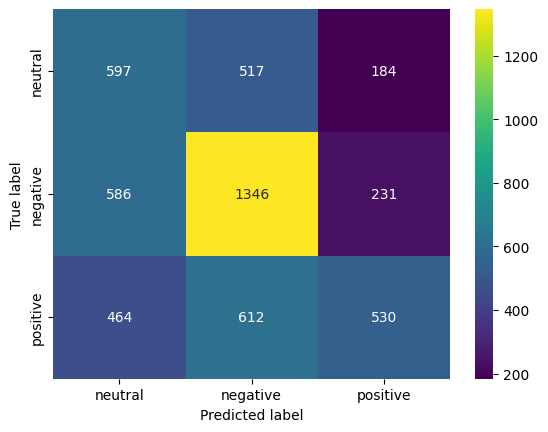

In [19]:
cf_matrix = confusion_matrix(y_true=Ytest, y_pred=y_pred)

sb.heatmap(cf_matrix,
           annot=True,
           fmt='d',
           cmap='viridis',
           xticklabels=['neutral','negative','positive'],
           yticklabels=['neutral','negative','positive'])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

* Logistic Regression

In [20]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(max_iter=1000,solver='saga')
clf.fit(Xtrain, Ytrain)
y_pred=clf.predict(Xtest)

In [21]:
print(classification_report(y_true=Ytest, y_pred=y_pred, target_names=['neutral','negative','positive']))

              precision    recall  f1-score   support

     neutral       0.36      0.46      0.41      1298
    negative       0.55      0.62      0.58      2163
    positive       0.56      0.34      0.42      1606

    accuracy                           0.49      5067
   macro avg       0.49      0.47      0.47      5067
weighted avg       0.50      0.49      0.48      5067



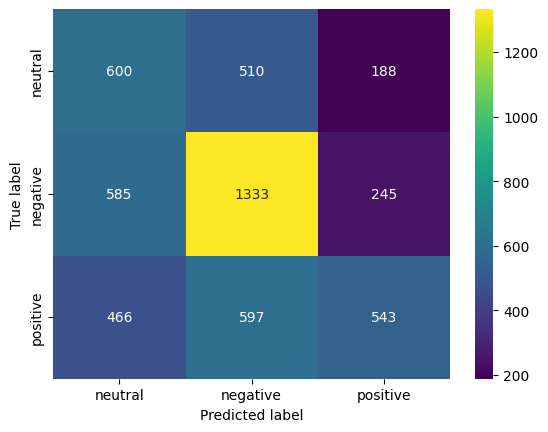

In [22]:
cf_matrix = confusion_matrix(y_true=Ytest, y_pred=y_pred)

sb.heatmap(cf_matrix,
           annot=True,
           fmt='d',
           cmap='viridis',
           xticklabels=['neutral','negative','positive'],
           yticklabels=['neutral','negative','positive'])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

* MLP

In [23]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(hidden_layer_sizes=(5), max_iter=1000, activation = 'relu', solver='adam', random_state=1)
clf.fit(Xtrain, Ytrain)
y_pred=clf.predict(Xtest)

In [24]:
print(classification_report(y_true=Ytest, y_pred=y_pred, target_names=['neutral','negative','positive']))

              precision    recall  f1-score   support

     neutral       0.37      0.46      0.41      1298
    negative       0.54      0.62      0.58      2163
    positive       0.54      0.33      0.41      1606

    accuracy                           0.49      5067
   macro avg       0.48      0.47      0.47      5067
weighted avg       0.50      0.49      0.48      5067



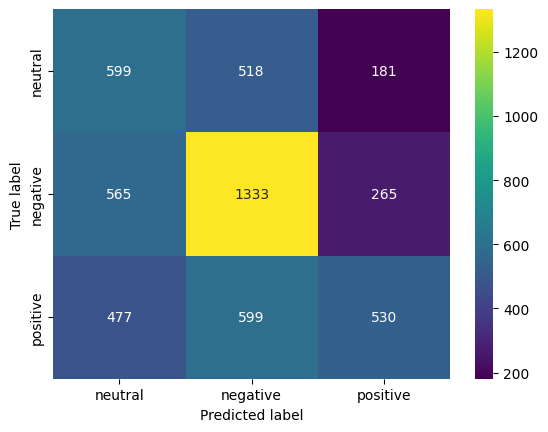

In [25]:
cf_matrix = confusion_matrix(y_true=Ytest, y_pred=y_pred)

sb.heatmap(cf_matrix,
           annot=True,
           fmt='d',
           cmap='viridis',
           xticklabels=['neutral','negative','positive'],
           yticklabels=['neutral','negative','positive'])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

# D) Pre-trained Model : Bert
## scheduler
## increase batch size 
## max_lenght check 


In [32]:
from transformers import AutoTokenizer
from torch.utils.data import DataLoader
from transformers import AdamW

In [33]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


In [34]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased", use_fast=True)

In [35]:
train_texts = training_data['sentences'].tolist()
train_labels = training_data['sentiment'].tolist()

valid_texts = valid_data['sentences'].tolist()
valid_labels = valid_data['sentiment'].tolist()

test_texts = test_data['sentences'].tolist()
test_labels = test_data['sentiment'].tolist()

In [36]:
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=128)
valid_encodings = tokenizer(valid_texts, truncation=True, padding=True, max_length=128)
test_encodings = tokenizer(test_texts, truncation=True, padding=True, max_length=128)

In [37]:
import torch

class MSDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = MSDataset(train_encodings, train_labels)
valid_dataset = MSDataset(valid_encodings, valid_labels)
test_dataset = MSDataset(test_encodings, test_labels)

In [38]:
from transformers import AutoModel, AdamW
from torch import nn

class TextClassifier(nn.Module):
  def __init__(self):
    super(TextClassifier, self).__init__()
    self.bert = AutoModel.from_pretrained('bert-base-uncased')
    self.fc1 = nn.Linear(768, 512)
    self.fc2 = nn.Linear(512, 64)
    self.fc3 = nn.Linear(64, 3)
    self.activation = nn.ReLU()
  
  def forward(self, input_ids, attention_mask):
    bert = self.bert(input_ids, attention_mask=attention_mask)[1]
    fc1 = self.fc1(bert)
    fc1 = self.activation(fc1)
    fc2 = self.fc2(fc1)
    fc2 = self.activation(fc2)
    fc3 = self.fc3(fc2)
    return bert,fc1,fc2,fc3

In [19]:
model = TextClassifier()
model.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


TextClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=Tru

In [40]:
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=True)

learning_rate = 5e-4
optim = torch.optim.AdamW(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optim, step_size=10, gamma=0.1)
loss_func = nn.CrossEntropyLoss().to(device)
     

In [41]:
for p in model.bert.parameters():
    p.requires_grad = False

In [43]:
from tqdm import tqdm
def train_loop(epoch, dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    avgLoss = 0
    avgCorrect = 0
    model.train()
    with tqdm(dataloader, unit="batch") as tepoch:
        for item in tepoch:
            tepoch.set_description(f"Epoch {epoch+1}")
            optimizer.zero_grad()
            size_batch = item['labels'].size()[0]
            # Compute prediction and loss
            input_ids = item['input_ids'].to(device)
            attention_mask = item['attention_mask'].to(device)
            labels = item['labels'].to(device)
            _,_,_,outputs = model(input_ids, attention_mask=attention_mask)
            loss = loss_fn(outputs, labels)
            avgLoss += loss.item()
            correct = (outputs.argmax(1) == labels).type(torch.float).sum().item()
            avgCorrect += correct
            
            # Backpropagation
            
            loss.backward()
            optimizer.step()
    
            correct = correct / size_batch
            
            tepoch.set_postfix(batch_loss=loss.item(), batch_accuracy=100. * correct)
            
    avgLoss /= len(dataloader)
    avgCorrect /= size
    print(f" -Training Accuracy (Avg) = {(100*avgCorrect):>0.1f}%, loss = {avgLoss:>8f} \n")
    return avgCorrect, avgLoss

def test_loop(dataloader, model, loss_fn, error):
    size = len(dataloader.dataset)
    avgLoss = 0
    avgCorrect = 0
    model.eval()
    with torch.no_grad():
        for item in dataloader:
            # Compute prediction and loss
            input_ids = item['input_ids'].to(device)
            attention_mask = item['attention_mask'].to(device)
            labels = item['labels'].to(device)
            _,_,_,outputs = model(input_ids, attention_mask=attention_mask)
            avgLoss += loss_fn(outputs, labels).item()
            avgCorrect += (outputs.argmax(1) == labels).type(torch.float).sum().item()

    avgLoss /= len(dataloader)
    avgCorrect /= size
    print(f" -{error} : Accuracy = {(100*avgCorrect):>0.1f}%, loss = {avgLoss:>8f} \n")
    return avgCorrect, avgLoss

In [25]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter(log_dir='tensorboard/Bert')

epochs = 30
for e in range(epochs):
    print(f" Epoch {e+1} -------------------------------")
    trainAcc, trainLoss = train_loop(e, train_loader, model, loss_func, optim)
    writer.add_scalar('Accuracy/train', trainAcc, e)
    writer.add_scalar('Loss/train', trainLoss, e)

    valAcc, valLoss = test_loop(valid_loader, model, loss_func, 'validation')
    writer.add_scalar('Accuracy/validation', valAcc, e)
    writer.add_scalar('Loss/validation', valLoss, e)
    # scheduler.step()
    
print("Done!")

 Epoch 1 -------------------------------


Epoch 1: 100%|██████████| 159/159 [00:08<00:00, 19.46batch/s, batch_accuracy=56.2, batch_loss=0.926]


 -Training Accuracy (Avg) = 49.5%, Avg loss = 1.004729 

 -validation : Accuracy = 46.4%, Avg loss = 0.008162 

 Epoch 2 -------------------------------


Epoch 2: 100%|██████████| 159/159 [00:08<00:00, 19.49batch/s, batch_accuracy=56.2, batch_loss=0.992]


 -Training Accuracy (Avg) = 52.9%, Avg loss = 0.968370 

 -validation : Accuracy = 54.4%, Avg loss = 0.007529 

 Epoch 3 -------------------------------


Epoch 3: 100%|██████████| 159/159 [00:08<00:00, 19.32batch/s, batch_accuracy=68.8, batch_loss=0.764]


 -Training Accuracy (Avg) = 54.4%, Avg loss = 0.950059 

 -validation : Accuracy = 53.8%, Avg loss = 0.007632 

 Epoch 4 -------------------------------


Epoch 4: 100%|██████████| 159/159 [00:08<00:00, 19.25batch/s, batch_accuracy=56.2, batch_loss=0.862]


 -Training Accuracy (Avg) = 54.9%, Avg loss = 0.938017 

 -validation : Accuracy = 52.0%, Avg loss = 0.007737 

 Epoch 5 -------------------------------


Epoch 5: 100%|██████████| 159/159 [00:08<00:00, 19.21batch/s, batch_accuracy=62.5, batch_loss=0.854]


 -Training Accuracy (Avg) = 55.6%, Avg loss = 0.935106 

 -validation : Accuracy = 50.6%, Avg loss = 0.007888 

 Epoch 6 -------------------------------


Epoch 6: 100%|██████████| 159/159 [00:08<00:00, 19.23batch/s, batch_accuracy=56.2, batch_loss=0.854]


 -Training Accuracy (Avg) = 55.9%, Avg loss = 0.929837 

 -validation : Accuracy = 54.4%, Avg loss = 0.007564 

 Epoch 7 -------------------------------


Epoch 7: 100%|██████████| 159/159 [00:08<00:00, 19.19batch/s, batch_accuracy=56.2, batch_loss=0.957]


 -Training Accuracy (Avg) = 56.8%, Avg loss = 0.921255 

 -validation : Accuracy = 56.0%, Avg loss = 0.007351 

 Epoch 8 -------------------------------


Epoch 8: 100%|██████████| 159/159 [00:08<00:00, 19.19batch/s, batch_accuracy=62.5, batch_loss=0.918]


 -Training Accuracy (Avg) = 56.7%, Avg loss = 0.926152 

 -validation : Accuracy = 56.7%, Avg loss = 0.007279 

 Epoch 9 -------------------------------


Epoch 9: 100%|██████████| 159/159 [00:08<00:00, 19.06batch/s, batch_accuracy=62.5, batch_loss=0.928]


 -Training Accuracy (Avg) = 56.3%, Avg loss = 0.924034 

 -validation : Accuracy = 55.7%, Avg loss = 0.007330 

 Epoch 10 -------------------------------


Epoch 10: 100%|██████████| 159/159 [00:08<00:00, 19.09batch/s, batch_accuracy=43.8, batch_loss=0.877]


 -Training Accuracy (Avg) = 57.0%, Avg loss = 0.917129 

 -validation : Accuracy = 57.0%, Avg loss = 0.007269 

 Epoch 11 -------------------------------


Epoch 11: 100%|██████████| 159/159 [00:08<00:00, 19.05batch/s, batch_accuracy=50, batch_loss=0.991]  


 -Training Accuracy (Avg) = 57.0%, Avg loss = 0.916104 

 -validation : Accuracy = 54.3%, Avg loss = 0.007500 

 Epoch 12 -------------------------------


Epoch 12: 100%|██████████| 159/159 [00:08<00:00, 19.02batch/s, batch_accuracy=81.2, batch_loss=0.773]


 -Training Accuracy (Avg) = 57.4%, Avg loss = 0.913103 

 -validation : Accuracy = 56.2%, Avg loss = 0.007329 

 Epoch 13 -------------------------------


Epoch 13: 100%|██████████| 159/159 [00:08<00:00, 19.02batch/s, batch_accuracy=75, batch_loss=0.783]  


 -Training Accuracy (Avg) = 57.0%, Avg loss = 0.916455 

 -validation : Accuracy = 54.3%, Avg loss = 0.007550 

 Epoch 14 -------------------------------


Epoch 14: 100%|██████████| 159/159 [00:08<00:00, 19.01batch/s, batch_accuracy=56.2, batch_loss=0.803]


 -Training Accuracy (Avg) = 57.0%, Avg loss = 0.911565 

 -validation : Accuracy = 56.2%, Avg loss = 0.007295 

 Epoch 15 -------------------------------


Epoch 15: 100%|██████████| 159/159 [00:08<00:00, 18.97batch/s, batch_accuracy=37.5, batch_loss=1.05] 


 -Training Accuracy (Avg) = 57.5%, Avg loss = 0.912700 

 -validation : Accuracy = 55.1%, Avg loss = 0.007380 

 Epoch 16 -------------------------------


Epoch 16: 100%|██████████| 159/159 [00:08<00:00, 18.92batch/s, batch_accuracy=75, batch_loss=0.751]  


 -Training Accuracy (Avg) = 57.5%, Avg loss = 0.910117 

 -validation : Accuracy = 56.7%, Avg loss = 0.007334 

 Epoch 17 -------------------------------


Epoch 17: 100%|██████████| 159/159 [00:08<00:00, 18.94batch/s, batch_accuracy=50, batch_loss=0.94]   


 -Training Accuracy (Avg) = 57.9%, Avg loss = 0.907080 

 -validation : Accuracy = 57.1%, Avg loss = 0.007258 

 Epoch 18 -------------------------------


Epoch 18: 100%|██████████| 159/159 [00:08<00:00, 18.95batch/s, batch_accuracy=50, batch_loss=0.856]  


 -Training Accuracy (Avg) = 57.6%, Avg loss = 0.906182 

 -validation : Accuracy = 56.1%, Avg loss = 0.007309 

 Epoch 19 -------------------------------


Epoch 19: 100%|██████████| 159/159 [00:08<00:00, 18.96batch/s, batch_accuracy=43.8, batch_loss=0.927]


 -Training Accuracy (Avg) = 57.9%, Avg loss = 0.907457 

 -validation : Accuracy = 56.7%, Avg loss = 0.007196 

 Epoch 20 -------------------------------


Epoch 20: 100%|██████████| 159/159 [00:08<00:00, 18.92batch/s, batch_accuracy=50, batch_loss=1.11]   


 -Training Accuracy (Avg) = 57.8%, Avg loss = 0.908668 

 -validation : Accuracy = 56.6%, Avg loss = 0.007310 

 Epoch 21 -------------------------------


Epoch 21: 100%|██████████| 159/159 [00:08<00:00, 18.88batch/s, batch_accuracy=62.5, batch_loss=0.798]


 -Training Accuracy (Avg) = 58.0%, Avg loss = 0.902940 

 -validation : Accuracy = 53.7%, Avg loss = 0.007631 

 Epoch 22 -------------------------------


Epoch 22: 100%|██████████| 159/159 [00:08<00:00, 18.83batch/s, batch_accuracy=50, batch_loss=0.995]  


 -Training Accuracy (Avg) = 58.0%, Avg loss = 0.903245 

 -validation : Accuracy = 57.0%, Avg loss = 0.007210 

 Epoch 23 -------------------------------


Epoch 23: 100%|██████████| 159/159 [00:08<00:00, 18.86batch/s, batch_accuracy=62.5, batch_loss=0.823]


 -Training Accuracy (Avg) = 58.1%, Avg loss = 0.903776 

 -validation : Accuracy = 52.3%, Avg loss = 0.007763 

 Epoch 24 -------------------------------


Epoch 24: 100%|██████████| 159/159 [00:08<00:00, 18.85batch/s, batch_accuracy=50, batch_loss=1.05]   


 -Training Accuracy (Avg) = 57.7%, Avg loss = 0.909159 

 -validation : Accuracy = 57.1%, Avg loss = 0.007162 

 Epoch 25 -------------------------------


Epoch 25: 100%|██████████| 159/159 [00:08<00:00, 18.86batch/s, batch_accuracy=75, batch_loss=0.886]  


 -Training Accuracy (Avg) = 58.2%, Avg loss = 0.902932 

 -validation : Accuracy = 56.4%, Avg loss = 0.007221 

 Epoch 26 -------------------------------


Epoch 26: 100%|██████████| 159/159 [00:08<00:00, 18.86batch/s, batch_accuracy=56.2, batch_loss=0.987]


 -Training Accuracy (Avg) = 58.0%, Avg loss = 0.902776 

 -validation : Accuracy = 55.3%, Avg loss = 0.007420 

 Epoch 27 -------------------------------


Epoch 27: 100%|██████████| 159/159 [00:08<00:00, 18.84batch/s, batch_accuracy=50, batch_loss=1.05]   


 -Training Accuracy (Avg) = 58.0%, Avg loss = 0.902613 

 -validation : Accuracy = 57.0%, Avg loss = 0.007157 

 Epoch 28 -------------------------------


Epoch 28: 100%|██████████| 159/159 [00:08<00:00, 18.87batch/s, batch_accuracy=81.2, batch_loss=0.783]


 -Training Accuracy (Avg) = 57.6%, Avg loss = 0.906258 

 -validation : Accuracy = 57.9%, Avg loss = 0.007161 

 Epoch 29 -------------------------------


Epoch 29: 100%|██████████| 159/159 [00:08<00:00, 18.68batch/s, batch_accuracy=62.5, batch_loss=0.849]


 -Training Accuracy (Avg) = 58.2%, Avg loss = 0.896731 

 -validation : Accuracy = 55.0%, Avg loss = 0.007505 

 Epoch 30 -------------------------------


Epoch 30: 100%|██████████| 159/159 [00:08<00:00, 18.72batch/s, batch_accuracy=68.8, batch_loss=0.692]


 -Training Accuracy (Avg) = 58.1%, Avg loss = 0.901565 

 -validation : Accuracy = 55.2%, Avg loss = 0.007438 

Done!


In [44]:
test_loop(test_loader, model, loss_func, 'Test');

 -Test : Accuracy = 56.6%, loss = 0.943510 



: 

In [29]:
y_pred = []
y_true = []

with torch.no_grad():
    for batch in tqdm(test_loader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        _,_,_,outputs = model(input_ids, attention_mask=attention_mask)
        y_pred.extend(outputs.argmax(1).cpu().numpy())
        y_true.extend(labels.cpu().numpy())

100%|██████████| 40/40 [00:02<00:00, 19.48it/s]


In [30]:
print(classification_report(y_true=y_true, y_pred=y_pred, target_names=['neutral','negative','positive']))

              precision    recall  f1-score   support

     neutral       0.41      0.60      0.49      1298
    negative       0.64      0.75      0.69      2163
    positive       0.73      0.29      0.42      1606

    accuracy                           0.57      5067
   macro avg       0.59      0.55      0.53      5067
weighted avg       0.61      0.57      0.55      5067



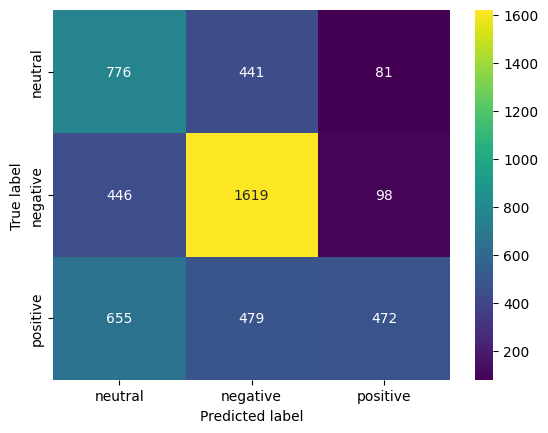

In [31]:
cf_matrix = confusion_matrix(y_true=y_true, y_pred=y_pred)

sb.heatmap(cf_matrix,
           annot=True,
           fmt='d',
           cmap='viridis',
           xticklabels=['neutral','negative','positive'],
           yticklabels=['neutral','negative','positive'])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

In [32]:
torch.save(model.state_dict(), 'checkpoints/bert.pth')

> Best Accuracy: 60 (Part4 BERT)\
Best f1-score: 69 (Part4 BERT) \
* > Glove word embeddings are context independent- these models output just one vector (embedding) for each word, combining all the different senses of the word into one vector.\
* > That is the one numeric representation of a word regardless of where the words occurs in a sentence and regardless of the different meanings they may have.\
* > BERT can generate different word embeddings for a word that captures the context of a word - that is its position in a sentence.\
* > BERT uses Transformer an attention based model with positional encodings to represent word positions.\
* > we can use word2vec and Glove vectors trained on a large corpus directly for downstream tasks. All we need is the vectors for the words. There is no need for the model itself that was used to train these vectors\
* > in the case of BERT, since they are context dependent, we need the model that was used to train the vectors even after training, since the models generate the vectors for a word based on context.